In [1]:
import numpy as np
import scanpy as sc
from scipy import io
import pandas as pd
import skmisc
import palantir
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# All data

In [14]:
base = "GSE211644"

# read matrix and metadata
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr() # transpose and make sparse for efficient storage
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
metadata = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv.gz", index_col=0)

# make AnnData object
adata = sc.AnnData(X=mat) # cell x gene matrix
adata.obs_names = barcodes.iloc[:, 0].astype(str).values # cells
adata.var_names = genes.iloc[:, 0].astype(str).values # genes

# add metadata to adata.obs
adata.obs = adata.obs.join(metadata)

In [15]:
barcodes = pd.Index(adata.obs_names)
mda1_mask = barcodes.str.startswith('MDA1_')
adata = adata[mda1_mask].copy()

In [16]:
sample_codes = pd.Series(adata.obs_names).str.split('_', expand=True)[1]
adata.obs['sample_type'] = np.where(
    sample_codes.str.startswith('T'),
    'tumor',
    'uninvolved'
)

In [17]:
adata.obs['sample_type'].value_counts()

sample_type
tumor         2637
uninvolved     508
Name: count, dtype: int64

In [18]:
# set seed
rng = 123

# layer
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# filter for highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="counts"
)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_hvg, random_state=rng)

/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


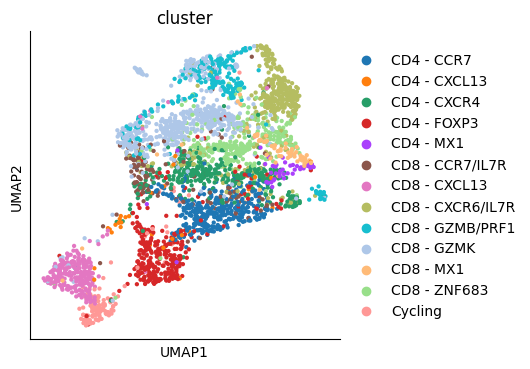

In [19]:
sc.pl.umap(adata_hvg, color='cluster')

In [20]:
# separate into cd4 and cd8 - use the original adata with counts
adata_cd4 = adata[adata.obs['cluster'].str.startswith('CD4'), :].copy()
adata_cd8 = adata[adata.obs['cluster'].str.startswith('CD8'), :].copy()

# CD4 pseudotime analysis

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


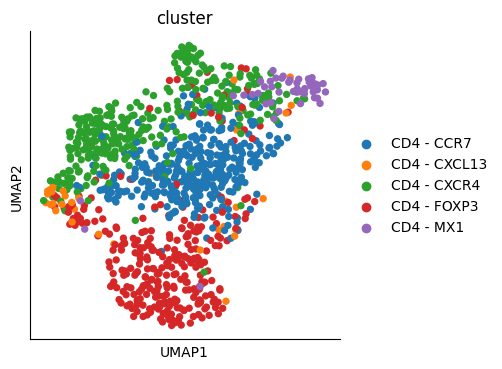

In [21]:
# preprocess cd4 data from scratch
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4, target_sum=1e4)
sc.pp.log1p(adata_cd4)
sc.pp.highly_variable_genes(adata_cd4, n_top_genes=2000, flavor="seurat_v3", layer="counts")
adata_cd4 = adata_cd4[:, adata_cd4.var['highly_variable']].copy()
sc.pp.scale(adata_cd4, max_value=10)
sc.tl.pca(adata_cd4, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_cd4, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_cd4, random_state=rng)
sc.pl.umap(adata_cd4, color='cluster')

In [22]:
dm_res = palantir.utils.run_diffusion_maps(adata_cd4, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(adata_cd4)
imputed_X = palantir.utils.run_magic_imputation(adata_cd4)

In [23]:
# Find cell with CCR7 expression near upper quartile
naive = adata_cd4[adata_cd4.obs['cluster'] == 'CD4 - CCR7']
ccr7_expr = naive[:, 'CCR7'].X.toarray().flatten()
q75 = np.percentile(ccr7_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(ccr7_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {adata_cd4.obs.loc[root_cell, 'cluster']}")
print(f"Root cell CCR7 expression: {ccr7_expr[closest_idx]:.3f}")

Selected root cell: MDA1_T04_CAGAATCTCATCACCC
Root cell cluster: CD4 - CCR7
Root cell CCR7 expression: 1.849


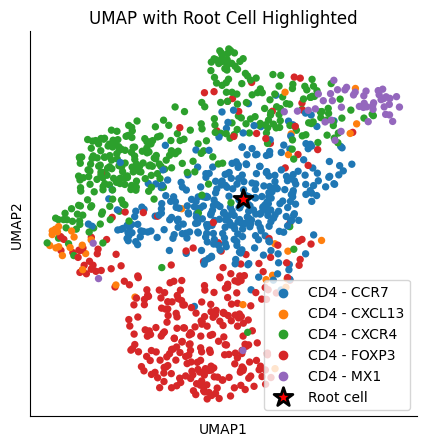

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(adata_cd4, color=['cluster'],ax=ax, show=False, cmap='viridis')

umap_coords = adata_cd4.obsm['X_umap']

root_idx = adata_cd4.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Root cell', zorder=10)

ax.legend(loc='best')
ax.set_title('UMAP with Root Cell Highlighted')
plt.show()

In [25]:
# Get unique clusters excluding CD4 - CCR7
clusters_to_find = adata_cd4.obs['cluster'][adata_cd4.obs['cluster'] != 'CD4 - CCR7'].unique()

# Find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    adata_cd4, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA1_T01_CTAGCCTGTAAGAGGA for cell type CD4 - FOXP3 which is min in diffusion component 0.
Using MDA1_T05_CAACTAGAGATGGGTC for cell type CD4 - CXCL13 which is min in diffusion component 6.
Using MDA1_T03_CGGGTCACAAGGTTCT for cell type CD4 - CXCR4 which is max in diffusion component 1.
Using MDA1_T01_AGGCCGTTCCACTCCA for cell type CD4 - MX1 which is max in diffusion component 3.


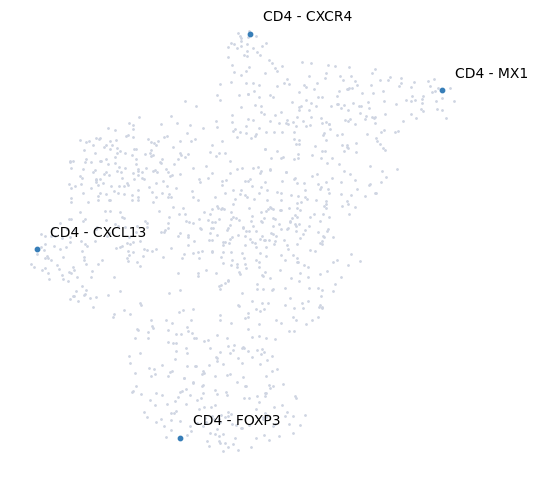

In [26]:
palantir.plot.highlight_cells_on_umap(adata_cd4, terminal_cells)
plt.show()

In [28]:
pr_res = palantir.core.run_palantir(
    adata_cd4, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.00022436777750651043 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.03963334957758586 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.8025
Correlation at iteration 2: 0.9988
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


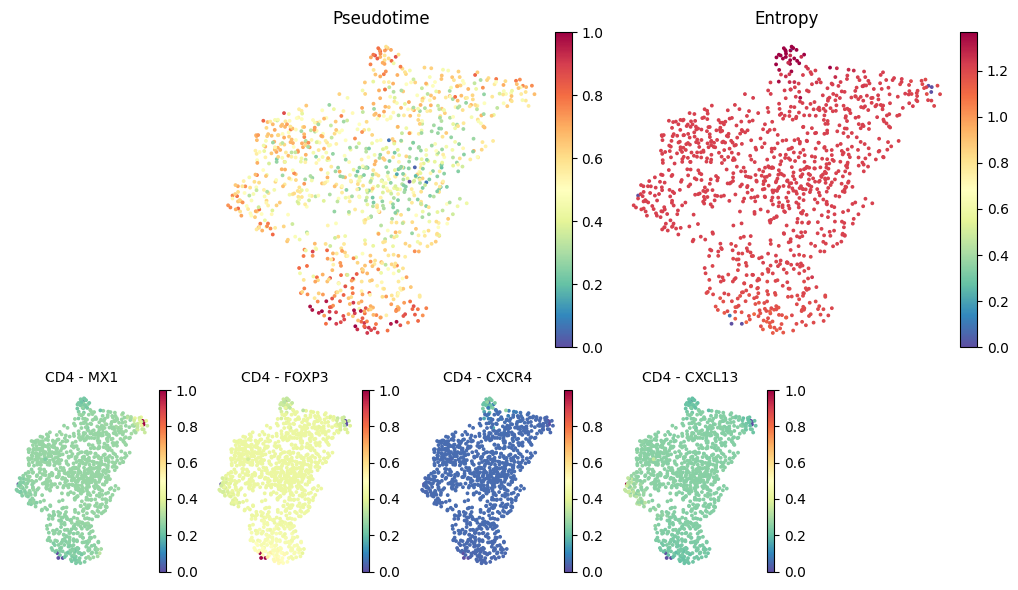

In [29]:
palantir.plot.plot_palantir_results(adata_cd4, s=3)
plt.show()

In [30]:
masks = palantir.presults.select_branch_cells(adata_cd4, q=.01, eps=.01)

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

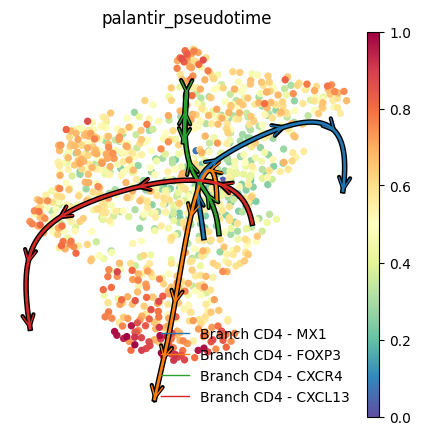

In [31]:
palantir.plot.plot_trajectories(adata_cd4, pseudotime_interval=(0, 1.0))

<Axes: >

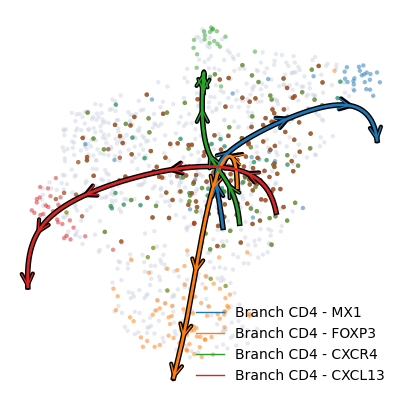

In [32]:
palantir.plot.plot_trajectories(adata_cd4, cell_color = "branch_selection", pseudotime_interval=(0, .9))

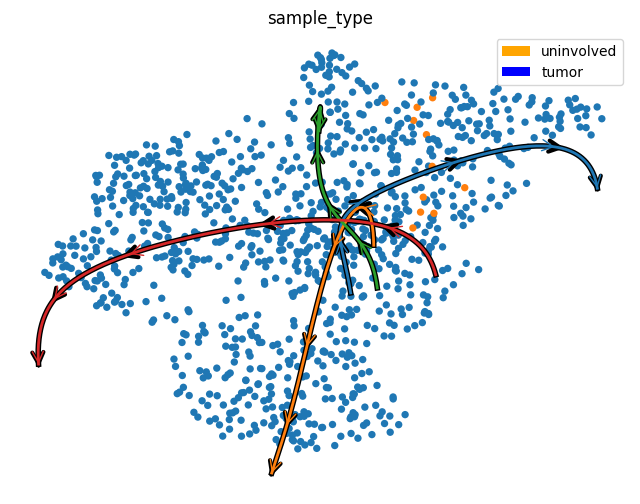

In [33]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(adata_cd4, cell_color="sample_type", pseudotime_interval=(0, .9), ax=ax)

# Get existing legend handles and labels (branch trajectories)
handles, labels = ax.get_legend_handles_labels()

# Filter to keep only the branch trajectory lines (not the scatter points)
branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

# Add sample type legend elements
sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

# Combine both legends
all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()

# CD8 pseudotime analysis

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


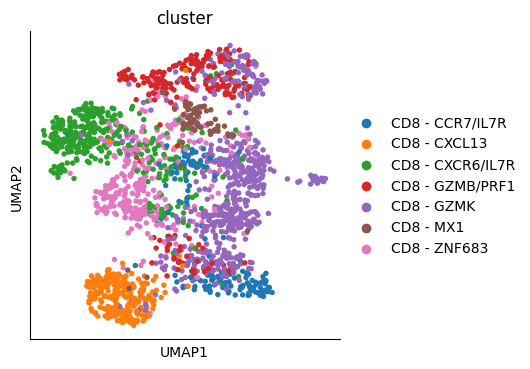

In [34]:
# preprocess cd8 data from scratch
adata_cd8.layers["counts"] = adata_cd8.X.copy()
sc.pp.normalize_total(adata_cd8, target_sum=1e4)
sc.pp.log1p(adata_cd8)
sc.pp.highly_variable_genes(adata_cd8, n_top_genes=2000, flavor="seurat_v3", layer="counts")
adata_cd8 = adata_cd8[:, adata_cd8.var['highly_variable']].copy()
sc.pp.scale(adata_cd8, max_value=10)
sc.tl.pca(adata_cd8, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_cd8, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_cd8, random_state=rng)
sc.pl.umap(adata_cd8, color='cluster')

In [35]:
dm_res = palantir.utils.run_diffusion_maps(adata_cd8, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(adata_cd8)
imputed_X = palantir.utils.run_magic_imputation(adata_cd8)

In [38]:
# Find cell with IL7R expression near upper quartile
naive = adata_cd8[adata_cd8.obs['cluster'] == 'CD8 - CCR7/IL7R']
il7r_expr = naive[:, 'IL7R'].X.toarray().flatten()
q75 = np.percentile(il7r_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(il7r_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {adata_cd8.obs.loc[root_cell, 'cluster']}")
print(f"Root cell IL7R expression: {il7r_expr[closest_idx]:.3f}")

Selected root cell: MDA1_T05_ACATACGCATCCCATC
Root cell cluster: CD8 - CCR7/IL7R
Root cell IL7R expression: 1.371


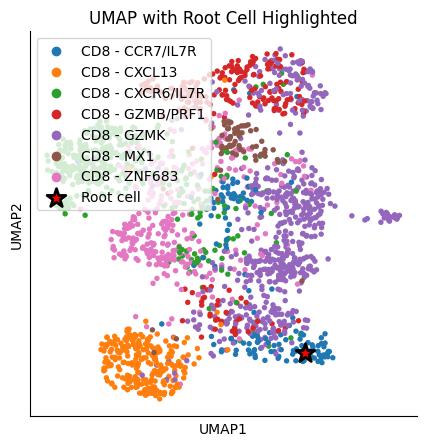

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(adata_cd8, color=['cluster'],ax=ax, show=False, cmap='viridis')

umap_coords = adata_cd8.obsm['X_umap']

root_idx = adata_cd8.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Root cell', zorder=10)

ax.legend(loc='upper left')
ax.set_title('UMAP with Root Cell Highlighted')
plt.show()

In [42]:
# Get unique clusters excluding CD8 - CCR7/IL7R
clusters_to_find = adata_cd8.obs['cluster'][adata_cd8.obs['cluster'] != 'CD8 - CCR7/IL7R'].unique()

# Find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    adata_cd8, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA1_T05_AAGGTTCTCGAGGTAG for cell type CD8 - CXCL13 which is min in diffusion component 2.
Using MDA1_T07_TACGGATCAGCTCCGA for cell type CD8 - ZNF683 which is min in diffusion component 6.
Using MDA1_U05_TTGAACGGTGTCCTCT for cell type CD8 - CXCR6/IL7R which is max in diffusion component 1.
Using MDA1_T03_GGAACTTCAATGGAGC for cell type CD8 - GZMB/PRF1 which is min in diffusion component 0.
Using MDA1_T04_CTTAACTGTCCAACTA for cell type CD8 - GZMK which is max in diffusion component 2.
Using MDA1_T01_ATCCACCGTGAACCTT for cell type CD8 - MX1 which is max in diffusion component 3.


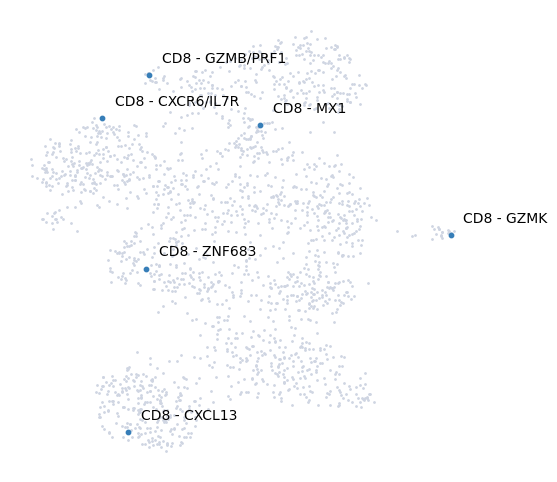

In [43]:
palantir.plot.highlight_cells_on_umap(adata_cd8, terminal_cells)
plt.show()

In [44]:
pr_res = palantir.core.run_palantir(
    adata_cd8, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.000364387035369873 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.04077643156051636 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9943
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


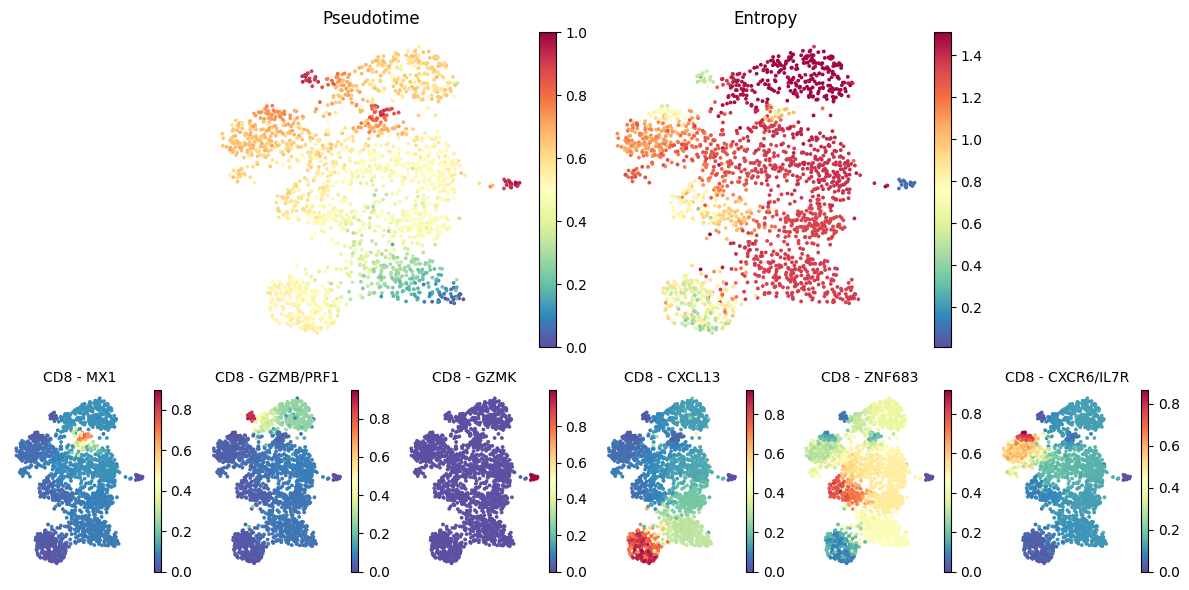

In [45]:
palantir.plot.plot_palantir_results(adata_cd8, s=3)
plt.show()

In [46]:
masks = palantir.presults.select_branch_cells(adata_cd8, q=.01, eps=.01)

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

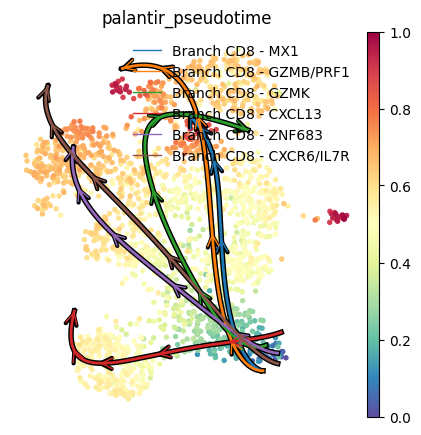

In [51]:
palantir.plot.plot_trajectories(adata_cd8, pseudotime_interval=(0, 1.0))

<Axes: >

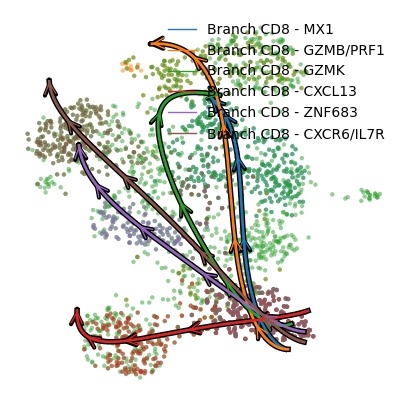

In [48]:
palantir.plot.plot_trajectories(adata_cd8, cell_color = "branch_selection", pseudotime_interval=(0, .9))

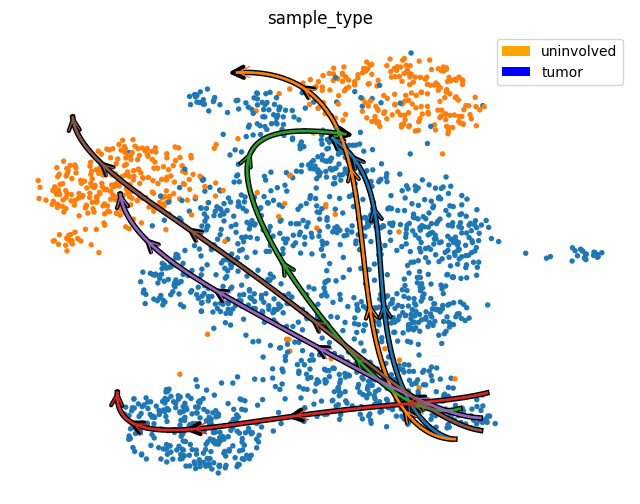

In [49]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(adata_cd8, cell_color="sample_type", pseudotime_interval=(0, .9), ax=ax)

# Get existing legend handles and labels (branch trajectories)
handles, labels = ax.get_legend_handles_labels()

# Filter to keep only the branch trajectory lines (not the scatter points)
branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

# Add sample type legend elements
sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

# Combine both legends
all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()